# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils

# Load trained models and data 

#### Set some variables used throughout

In [2]:
dataroot = "/home/data/world-cities/"

nz   = 100
ngf  = 16
ndf  = 16
nc   = 1
imageSize = 64
batchSize = 64
workers   = 4

experiment_root = "/home/data/pytorch-workspace/DCGAN/"

experiment_dir = experiment_root + "16-weak-cond-2pct-6" # "16-weak-cond-2pct-5/" 

#### Plot fake and real data

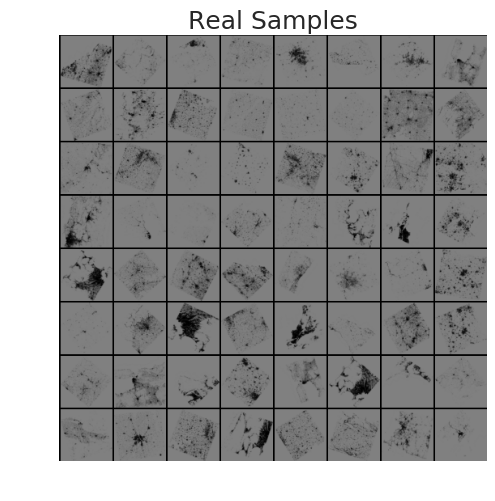

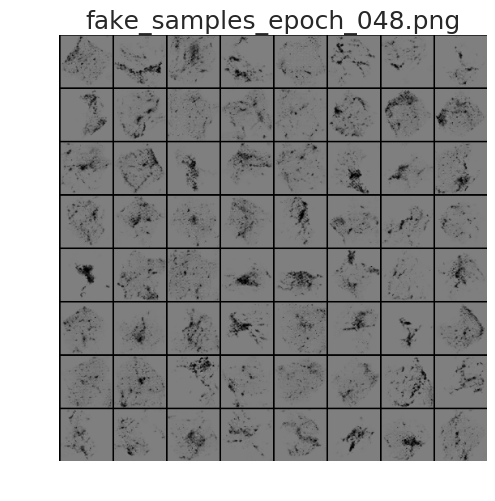

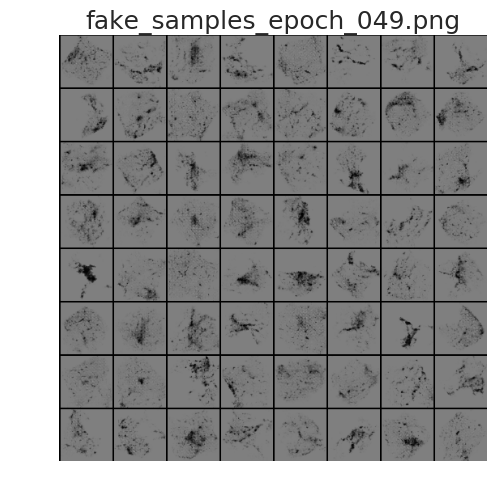

In [3]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

img_real = imread(files_real[0])
img_real = img_real / float(img_real.max())
plt.imshow(1-np.abs(img_real))
plt.title("Real Samples")
plt.axis("off")
plt.show()

for f in files_fake[-2:]:
    img = imread(f)
    img = img / float(img.max())
    plt.imshow(1 - np.abs(img))
    plt.title(os.path.basename(f))
    plt.axis("off")
    plt.show()


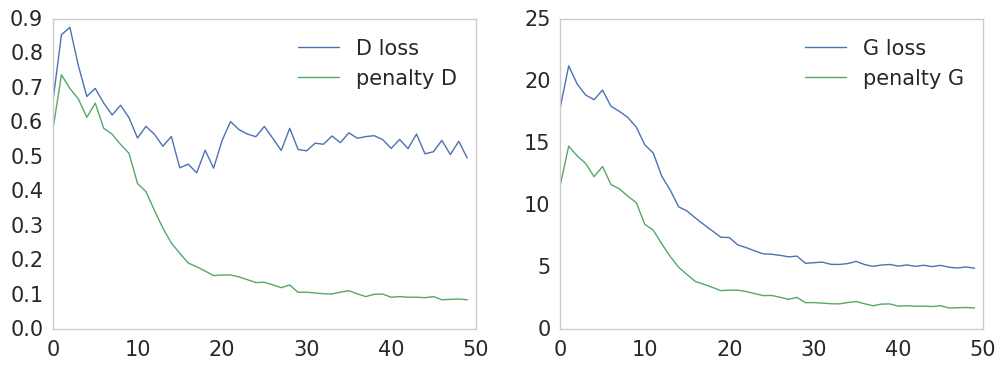

In [4]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "/training-loss.pickle.gz", "r") as f:
    lossD, lossG, lossED, lossEG = pickle.load(f)
    # lossD, lossG, lossE = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)
lossED = np.array(lossED)
lossEG = np.array(lossEG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].plot(lossED[:,0], label="penalty D")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].plot(lossEG[:,0], label="penalty G")
ax[1].legend()

#### Load last checkpointed generator model

In [5]:
files_cptG = glob.glob(experiment_dir + "/netG*.pth")
files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}
netG_ckpt = files_cptG[np.argmax(files_cptG.keys())]
print netG_ckpt

/home/data/pytorch-workspace/DCGAN/16-weak-cond-2pct-6/netG_epoch_49.pth


In [8]:
sys.path.append("../ml-model/")
import models.dcgan_orig as do

ngpu = 2
ncond= 1
netG = do._netG(ngpu, nc, nz + ncond, ngf)

netG.load_state_dict(torch.load(netG_ckpt))
# if torch.cuda.is_available():
#     netG.cuda()

# Generate synthetic images

#### Generate synthetic samples and compare statistics

In [102]:
def generate_samples(Z, cond=None, cuda=False, batchSize=64):
    '''
    Z (and cond, if provided) are numpy arrays.
    '''
    N, nz = Z.shape
    idx_batch = np.array_split(range(N), int(np.ceil(N / batchSize)))
    Zv  = torch.FloatTensor(batchSize, nz, 1, 1)
    if cuda:
        Zv = Zv.cuda()
        netG.cuda()
    else:
        netG.cpu()
    Zv = Variable(Zv)
    if cond is not None:
        ncond = cond.shape[1]
        condv = torch.FloatTensor(batchSize, ncond, 1, 1)
        if cuda:
            condv = condv.cuda()
        condv = Variable(condv)
    fake = []
    for idx in idx_batch:
        Zv.data.resize_(len(idx),nz,1,1).copy_(torch.from_numpy(Z[idx,:].reshape(len(idx),nz,1,1)))
        if cond is not None:
            condv.data.resize_(len(idx), ncond, 1, 1).copy_(torch.from_numpy(cond[idx]))
        else:
            condv = None
        fake_batch = netG(Zv, cond=condv)
        fake.append(fake_batch)
    fake = torch.cat(fake, 0)
    # put result back to CPU
    if cuda:
        fake = fake.cpu()
    return fake

In [30]:
def compute_stats(batch):
    return batch.abs().mean(2).mean(3)

0.0524195
0.833564719657 0.00346549909306


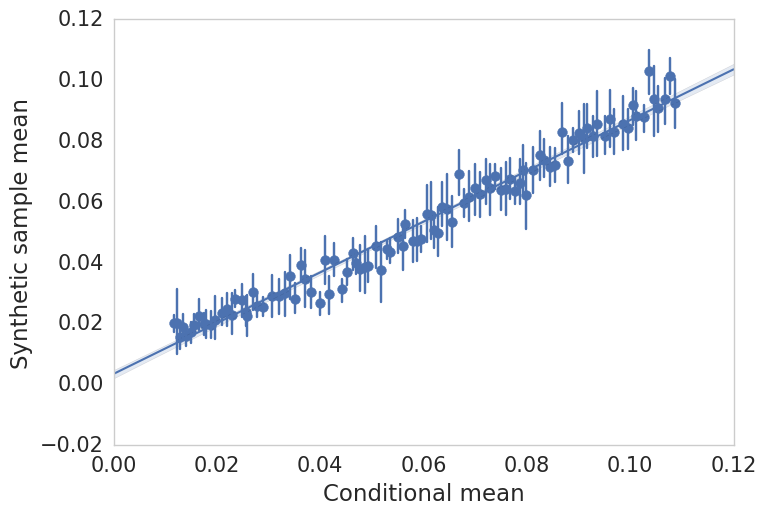

In [37]:
N = 1000

Z = np.random.randn(N, nz)
cond = 0.01 + np.random.rand(N,1) * 0.1

fake = generate_samples(Z, cond=cond, cuda=True)

stats_fake = compute_stats(fake)
stats_fake_np = stats_fake.data.numpy().squeeze()
print stats_fake_np.mean()

# compute correlation coefficient
from scipy import polyfit
(ar,br)=polyfit(cond[:,0],stats_fake_np,1)
print ar, br

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

tips = sns.load_dataset("tips")
ax = sns.regplot(x=cond, y=stats_fake_np, x_bins=100)
ax.set_xlabel("Conditional mean")
ax.set_ylabel("Synthetic sample mean")

(array([ 20.,  62.,  82.,  97.,  71.,  93.,  63.,  69.,  70.,  71.,  70.,
         60.,  58.,  44.,  26.,  29.,   7.,   7.,   0.,   1.]),
 array([ 0.00400657,  0.01045471,  0.01690285,  0.02335099,  0.02979913,
         0.03624727,  0.04269541,  0.04914354,  0.05559168,  0.06203982,
         0.06848796,  0.0749361 ,  0.08138424,  0.08783238,  0.09428052,
         0.10072866,  0.10717679,  0.11362493,  0.12007307,  0.12652121,
         0.13296935]),
 <a list of 20 Patch objects>)

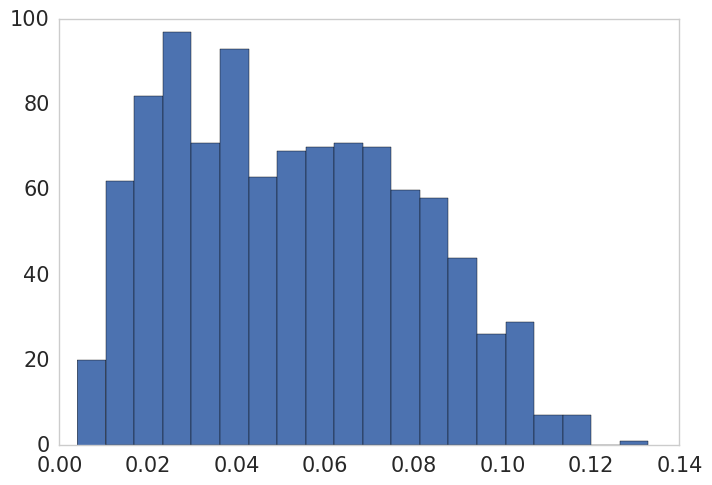

In [38]:
plt.hist(stats_fake_np, 20)

# Explore latent space 
 - a way to assess representation quality introduced in the DCGAN paper

0.0520192


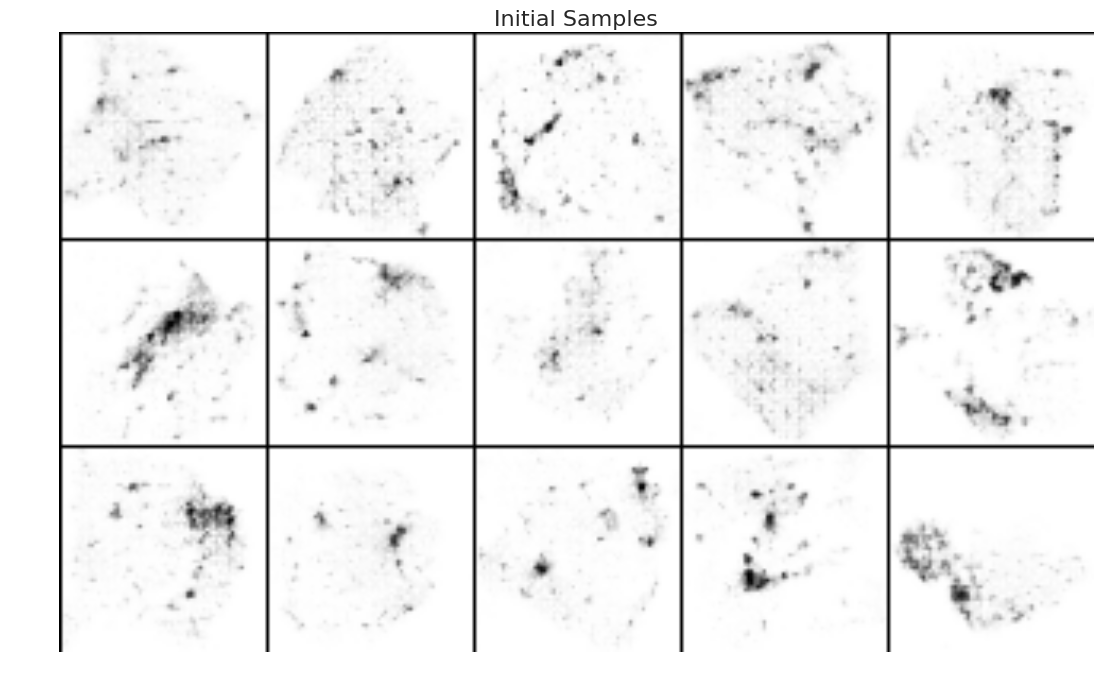

In [40]:
N = 100

Z = np.random.randn(N, nz)
cond = np.ones((N,1)) * 0.06

fake = generate_samples(Z, cond=cond)

stats_fake = compute_stats(fake)
stats_fake_np = stats_fake.data.numpy().squeeze()
print stats_fake_np.mean()

canvas = vutils.make_grid(fake.data[:15], nrow=5, padding=1).numpy()

plt.figure(figsize=(16,8))
plt.imshow(np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Initial Samples", fontsize=16)

(array([  1.,   1.,   0.,   1.,   3.,   4.,   6.,   7.,   2.,  13.,  12.,
          8.,   9.,   5.,   8.,   6.,   4.,   4.,   3.,   3.]),
 array([ 0.01794802,  0.02095483,  0.02396165,  0.02696847,  0.02997528,
         0.0329821 ,  0.03598892,  0.03899573,  0.04200255,  0.04500937,
         0.04801618,  0.051023  ,  0.05402982,  0.05703663,  0.06004345,
         0.06305027,  0.06605708,  0.0690639 ,  0.07207072,  0.07507753,
         0.07808435]),
 <a list of 20 Patch objects>)

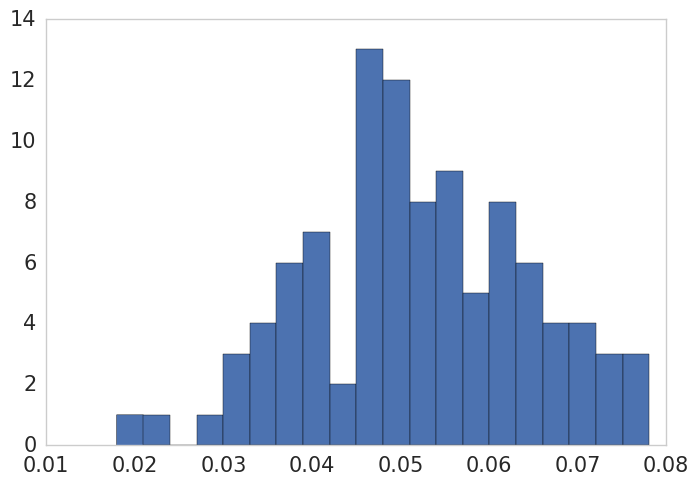

In [41]:
plt.hist(stats_fake_np, bins=20)

#### Generate interpolation map

In [42]:
def generate_interpolation_map(Z,M):
    N, nz = Z.shape
    Z_map = np.zeros((N-1,M+1,nz))
    for n in range(N-1):
        dZ = (Z[n+1,:] - Z[n,:]) / float(M)
        for m in range(M+1):
            Z_map[n,m,:] = Z[n,:] + m*dZ
    Z_map = Z_map.reshape(((N-1)*(M+1), nz))
    return Z_map

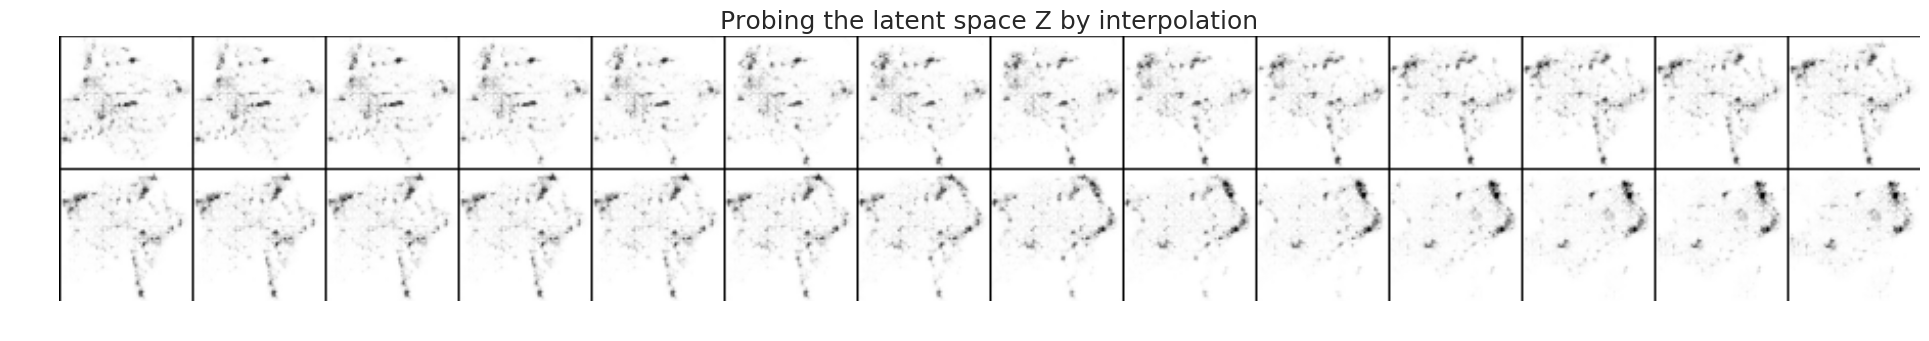

In [44]:
M = 15

Z_map = generate_interpolation_map(Z[[0,3,12]], M)
fake_map = generate_samples(Z_map, cond=cond, batchSize=1)

canvas = vutils.make_grid(fake_map.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(24,10))
plt.imshow(np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Probing the latent space Z by interpolation")

# Morph between real samples

#### Load info on real samples

In [48]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['phase'] = 'train'

len(files_df)

24986

In [65]:
from skimage.transform import resize 

def read_img(f, imgSize=None):
    img = imread(f)
    img[img==128] = 0 # this removes gray patches that indicate no data/water bodies
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = img / 255.0
    img = img - 0.5
    return img

In [66]:
mycities = ["paris, fr", "moscow, ru", "lagos, ng", "san francisco, us", "new delhi, in", "boston, us"]

image_dict = {}
for c in mycities:
    f = files_df[files_df.city.str.contains(c)]['filename'].iloc[0]
    image_dict[c] = read_img(f, 64)
    
img_batch = np.expand_dims(np.array(image_dict.values()), 1)

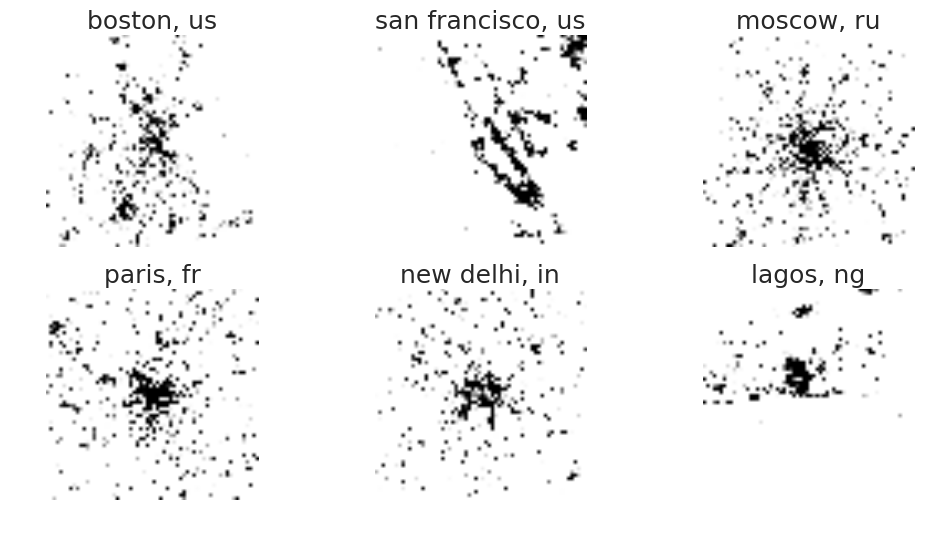

In [67]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
for k, (c, img) in enumerate(image_dict.iteritems()):
    i = k / 3
    j = k % 3
    ax[i,j].imshow(img)
    ax[i,j].axis("off")
    ax[i,j].set_title(c)

#### Given a real image, find latent representation via optimization of 
$
    \displaystyle  e_r = | x_r - G(z_r)|
$

per the BEGAN paper.

In [45]:
import torch.optim as optim

In [96]:
crit_l1 = nn.L1Loss()
netG = netG.cuda()

def compute_latent_representation(img_batch, niter=5000, lr=0.02):
    batch_size, nc, imgSize, _ = img_batch.shape
    Zv = torch.rand(batch_size, nz+1, 1, 1).type(torch.FloatTensor)
    Zv[:,-1,:,:] = 0.05
    Zv = Zv.cuda()
    Zv = Variable(Zv, requires_grad=True)
    imgv = torch.FloatTensor(img_batch)
    imgv = imgv.cuda()
    imgv = Variable(imgv, requires_grad=False)

    optimizer = optim.Adam([Zv], lr=lr, betas=(0.5, 0.999))

    # make sure generator parameters are fixed
    for param in netG.parameters():
        param.requires_grad = False

    loss_hist = []
    for i in range(niter):
        # Forward + Backward + Optimize
        fake = netG(Zv)
        loss = crit_l1(fake.abs(), imgv)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_hist.append(loss.data[0])
        if i % 10000 == 0:
            print '[%d/%d] Loss: %.4f' % (i, niter, loss.data[0])
    
    return Zv, loss_hist

In [93]:
img = image_dict['san francisco, us']
img1 = np.expand_dims(np.expand_dims(img,0),0)

Zv, loss_hist = compute_latent_representation(img1, niter=50000, lr=0.0001) # 0.0002
Z_np = Zv.data.cpu().numpy().squeeze()

[0/50000] Loss: 0.5330
[1000/50000] Loss: 0.5212
[2000/50000] Loss: 0.5150
[3000/50000] Loss: 0.5108
[4000/50000] Loss: 0.5077
[5000/50000] Loss: 0.5050
[6000/50000] Loss: 0.5030
[7000/50000] Loss: 0.5015
[8000/50000] Loss: 0.4998
[9000/50000] Loss: 0.4986
[10000/50000] Loss: 0.4976
[11000/50000] Loss: 0.4967
[12000/50000] Loss: 0.4960
[13000/50000] Loss: 0.4955
[14000/50000] Loss: 0.4952
[15000/50000] Loss: 0.4949
[16000/50000] Loss: 0.4947
[17000/50000] Loss: 0.4945
[18000/50000] Loss: 0.4943
[19000/50000] Loss: 0.4943
[20000/50000] Loss: 0.4942
[21000/50000] Loss: 0.4942
[22000/50000] Loss: 0.4942
[23000/50000] Loss: 0.4941
[24000/50000] Loss: 0.4941
[25000/50000] Loss: 0.4941
[26000/50000] Loss: 0.4940
[27000/50000] Loss: 0.4940
[28000/50000] Loss: 0.4939
[29000/50000] Loss: 0.4939
[30000/50000] Loss: 0.4939
[31000/50000] Loss: 0.4938
[32000/50000] Loss: 0.4938
[33000/50000] Loss: 0.4938
[34000/50000] Loss: 0.4938
[35000/50000] Loss: 0.4937
[36000/50000] Loss: 0.4937
[37000/50000] 

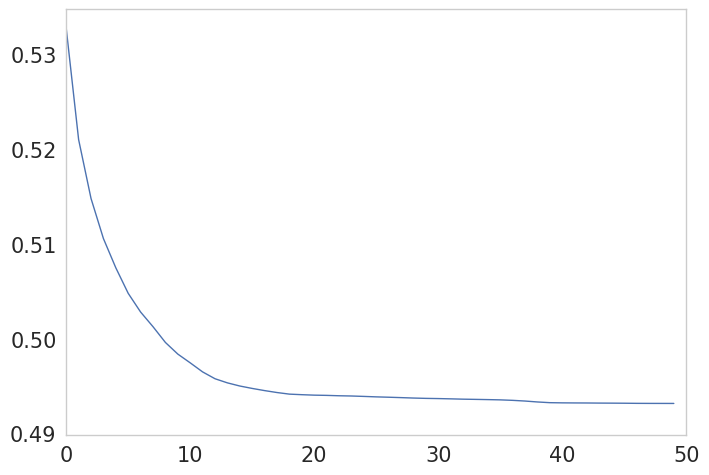

In [94]:
plt.plot(loss_hist[:-1:1000])

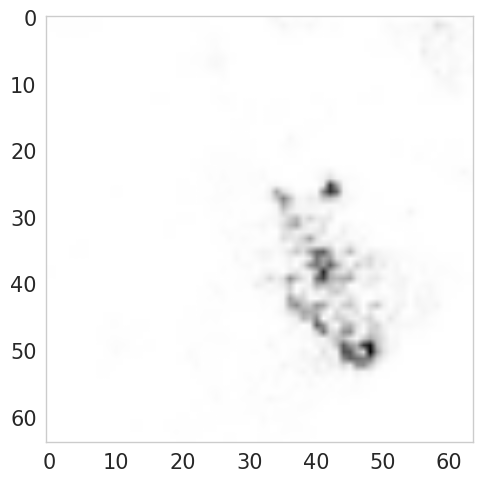

In [95]:
fake = netG(Zv)
img_rec = fake.data.cpu().numpy().squeeze()
plt.imshow(np.abs(img_rec))

In [97]:
Z_mycities = []
for c, img in image_dict.iteritems():
    print c
    img1 = np.expand_dims(np.expand_dims(img,0),0)
    Zv, loss_hist = compute_latent_representation(img1, niter=50000, lr=0.0001)
    Z_np = Zv.data.cpu().numpy().squeeze()
    Z_mycities.append(Z_np)

boston, us
[0/50000] Loss: 0.5226
[10000/50000] Loss: 0.4929
[20000/50000] Loss: 0.4903
[30000/50000] Loss: 0.4886
[40000/50000] Loss: 0.4885
san francisco, us
[0/50000] Loss: 0.5352
[10000/50000] Loss: 0.4984
[20000/50000] Loss: 0.4943
[30000/50000] Loss: 0.4937
[40000/50000] Loss: 0.4933
moscow, ru
[0/50000] Loss: 0.5099
[10000/50000] Loss: 0.4840
[20000/50000] Loss: 0.4826
[30000/50000] Loss: 0.4826
[40000/50000] Loss: 0.4826
paris, fr
[0/50000] Loss: 0.5264
[10000/50000] Loss: 0.4894
[20000/50000] Loss: 0.4869
[30000/50000] Loss: 0.4865
[40000/50000] Loss: 0.4863
new delhi, in
[0/50000] Loss: 0.5260
[10000/50000] Loss: 0.4958
[20000/50000] Loss: 0.4927
[30000/50000] Loss: 0.4918
[40000/50000] Loss: 0.4913
lagos, ng
[0/50000] Loss: 0.5432
[10000/50000] Loss: 0.5010
[20000/50000] Loss: 0.4992
[30000/50000] Loss: 0.4988
[40000/50000] Loss: 0.4984


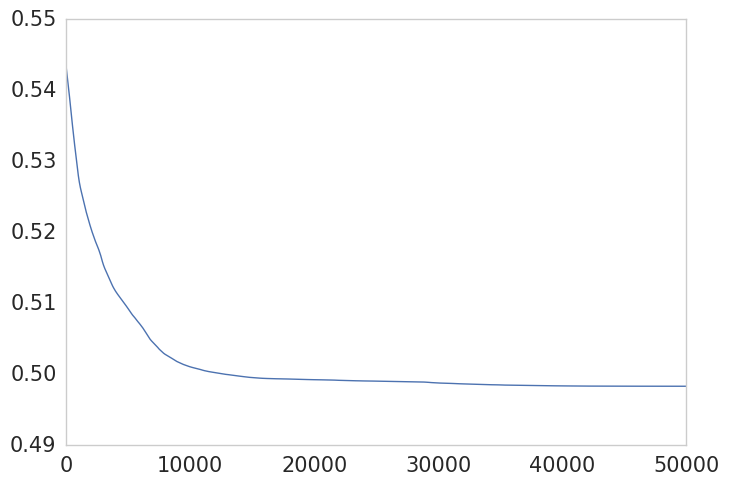

In [98]:
plt.plot(loss_hist)

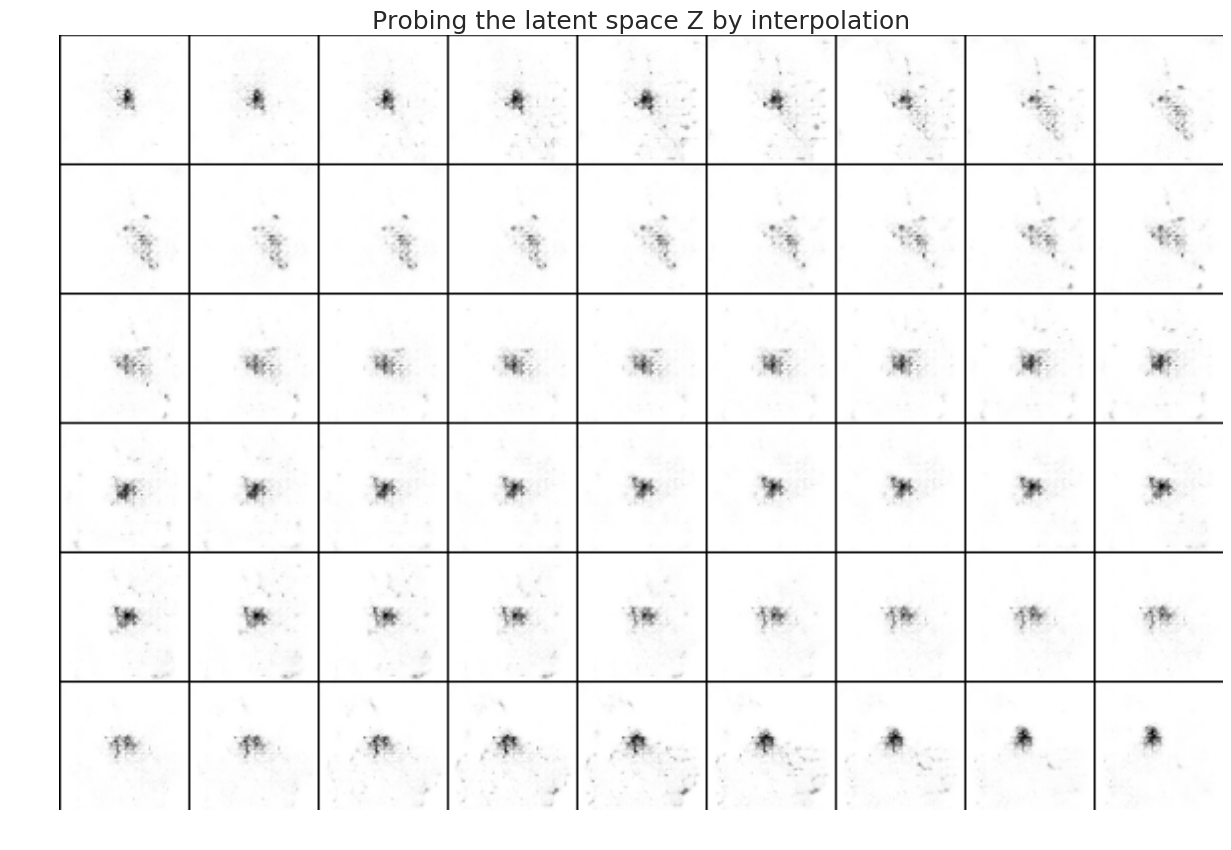

In [105]:
M = 10

Z_map = generate_interpolation_map(np.array(Z_mycities), M)
fake = generate_samples(Z_map, cuda=True, batchSize=1)

canvas = vutils.make_grid(fake.data.cpu(), nrow=M-1, padding=1).numpy()

plt.figure(figsize=(24,10))
plt.imshow(np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Probing the latent space Z by interpolation")